In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from os import listdir
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import lasio
from sklearn.metrics import mean_absolute_error as mae


In [2]:
las_files = listdir('init/1/las_train2/')

In [3]:
las = {}
for las_file in las_files[:5]:
    las[las_file[:-4]] = (lasio.read('init/1/las_train2/{}'.format(las_file))).df()

Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.


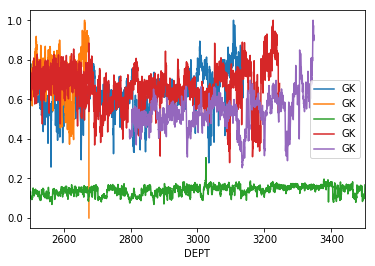

In [11]:
#(df_las[['GK', 'BK', 'IK', 'GZ1']]/df_las[['GK', 'BK', 'IK', 'GZ1']].max()).plot()
for key in las.keys():
    (las[key]['GK']/las[key]['GK'].max()).plot()
ax = plt.gca()
ax.set_xlim(2500, 3500)
ax.legend()

In [1]:
list(las.keys())

NameError: name 'las' is not defined

In [ ]:
km_anom = KMeans(n_clusters=2)

In [ ]:
X = las.loc[3200:3300, 'GK'].values

In [ ]:
df_las.loc[3200:3300, 'anom'] = km_anom.fit_predict(X.reshape(-1,1))